<a href="https://colab.research.google.com/github/raymondlimzisin/Handwritten-Chinese-Character-Recognition-Using-Transfer-Learning/blob/main/CASIA_128px.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders
import splitfolders  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
import sklearn
import time
import tqdm
import pandas as pd
import numpy as np
import keras
import plotly.graph_objects as go
import tensorflow
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm
from keras.models import Sequential, load_model
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import vgg16
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [ ]:
print("tensorflow:", tensorflow. __version__)
print("keras:", keras. __version__)
print('sklearn: {}'.format(sklearn.__version__))

tensorflow: 2.8.2
keras: 2.8.0
sklearn: 1.0.2


In [ ]:
os.mkdir('/content/drive/MyDrive/NewFYP/CASIA')
os.mkdir('/content/drive/MyDrive/NewFYP/CASIA_128px')

In [ ]:
!unzip -u "/content/drive/My Drive/NewFYP/CASIA.zip" -d "/content/drive/My Drive/NewFYP/CASIA"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Archive:  /content/drive/My Drive/NewFYP/CASIA.zip
   creating: /content/drive/My Drive/NewFYP/CASIA/光/
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/1.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/10.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/100.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/101.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/102.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/103.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/104.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/105.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/106.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/107.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/108.png  
  inflating: /content/drive/My Drive/NewFYP/CASIA/光/109.png  
  inflating: /content/drive/My Drive/Ne

In [3]:
%cd "/content/drive/MyDrive/NewFYP/CASIA"
!ls

/content/drive/MyDrive/NewFYP/CASIA
model.png  厂  及  呼  滨  烟  煤  熟  突  类  粮
光	   厉  呜  堂  滩  烦  熄  男  窗  粉


In [ ]:
input_folder = '/content/drive/MyDrive/NewFYP/CASIA'

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/NewFYP/CASIA_128px", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 2845 files [15:42,  3.02 files/s]


In [ ]:
columns = ["Character_ID", "Character", "Paths", "Directory", "File_Name"]
IDS = []
characters = []
paths = []
files_names = []
directories_names = []

id = -1

paths_dirs = ["train", "val", "test"]
ROOT_PATH = "/content/drive/MyDrive/NewFYP/CASIA_128px/"
for path_dir in paths_dirs:
    PATH = f"{ROOT_PATH}{path_dir}"
    
    for directory in tqdm_notebook(os.listdir(PATH)):
        id += 1
        for file in os.listdir(f"{PATH}/{directory}"):
            IDS.append(id)
            characters.append(directory)
            paths.append(f"{PATH}/{directory}/{file}")
            files_names.append(file)
            directories_names.append(path_dir)

data = pd.DataFrame({columns[0] : IDS,
                     columns[1] : characters,
                     columns[2] : paths,
                     columns[3] : directories_names,
                     columns[4] : files_names})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
data

,Character_ID,Character,Paths,Directory,File_Name
0,0,滩,/content/drive/MyDrive/NewFYP/CASIA_128px/trai...,train,38.png
1,0,滩,/content/drive/MyDrive/NewFYP/CASIA_128px/trai...,train,100.png
2,0,滩,/content/drive/MyDrive/NewFYP/CASIA_128px/trai...,train,129.png
3,0,滩,/content/drive/MyDrive/NewFYP/CASIA_128px/trai...,train,32.png
4,0,滩,/content/drive/MyDrive/NewFYP/CASIA_128px/trai...,train,81.png
...,...,...,...,...,...
2840,59,厉,/content/drive/MyDrive/NewFYP/CASIA_128px/test...,test,130.png
2841,59,厉,/content/drive/MyDrive/NewFYP/CASIA_128px/test...,test,23.png
2842,59,厉,/content/drive/MyDrive/NewFYP/CASIA_128px/test...,test,33.png
2843,59,厉,/content/drive/MyDrive/NewFYP/CASIA_128px/test...,test,104.png


In [ ]:
print(f"There are {data.shape[0]} images in whole dataset.")
print(f"{len(data[data['Directory'] == 'train'])} images in Train part, {len(data[data['Directory'] == 'val'])} in Val part and {len(data[data['Directory'] == 'test'])} in Test part.")
print(f"{round(np.array(data['Character_ID']).max() /3)} characters (classes).")

There are 2845 images in whole dataset.
1983 images in Train part, 560 in Val part and 302 in Test part.
20 characters (classes).


In [ ]:
def count_of_each_character(directory):
    count_numbers = []
    classes = []

    j = 0
    PATH = f"/content/drive/MyDrive/NewFYP/CASIA_128px/{directory}"
    for character in os.listdir(PATH):
        classes.append(character)
        for image in os.listdir(os.path.join(PATH, character)):
            j += 1

        count_numbers.append(j)
        j = 0

    fig = go.Figure(data = [go.Bar(x = classes, y = count_numbers, marker_color = "green")])

    fig.update_layout(title = f"Distribution of count of Images in {directory} dataset", xaxis_title = "Characters", yaxis_title = "Count", legend_title = "Legend")
    fig.update_layout(barmode = "group", xaxis={'categoryorder' : 'total descending'}, xaxis_tickangle = 0)

    fig.show()

In [ ]:
count_of_each_character("train")

In [ ]:
count_of_each_character("val")

In [ ]:
count_of_each_character("test")

# **Image Processing for 224x224px images**

In [4]:
train_path="/content/drive/MyDrive/NewFYP/CASIA_128px/train"
test_path="/content/drive/MyDrive/NewFYP/CASIA_128px/test"
val_path="/content/drive/MyDrive/NewFYP/CASIA_128px/val"

In [6]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [7]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [8]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [9]:
train_x.shape, val_x.shape, test_x.shape

((1983, 224, 224, 3), (560, 224, 224, 3), (302, 224, 224, 3))

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   brightness_range = (0.5,1.5),
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   fill_mode='constant', cval=255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1983 images belonging to 20 classes.
Found 302 images belonging to 20 classes.
Found 560 images belonging to 20 classes.


In [12]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [13]:
training_set.class_indices

{'光': 0,
 '厂': 1,
 '厉': 2,
 '及': 3,
 '呜': 4,
 '呼': 5,
 '堂': 6,
 '滨': 7,
 '滩': 8,
 '烟': 9,
 '烦': 10,
 '煤': 11,
 '熄': 12,
 '熟': 13,
 '男': 14,
 '突': 15,
 '窗': 16,
 '类': 17,
 '粉': 18,
 '粮': 19}

In [14]:
train_y.shape,test_y.shape,val_y.shape

((1983,), (302,), (560,))

# **Basic VGG16 Model**


In [15]:
image_input = Input(shape=(224, 224, 3))

vgg16 = VGG16(input_tensor=image_input, weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [16]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(4096,activation = "relu")(X)
X = Dense(4096,activation = "relu" )(X)
X = Dense(20,activation= "softmax")(X)

BasicModel = Model(inputs=vgg16.input, outputs=X)

In [17]:
# view the structure of the model
BasicModel.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(BasicModel.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

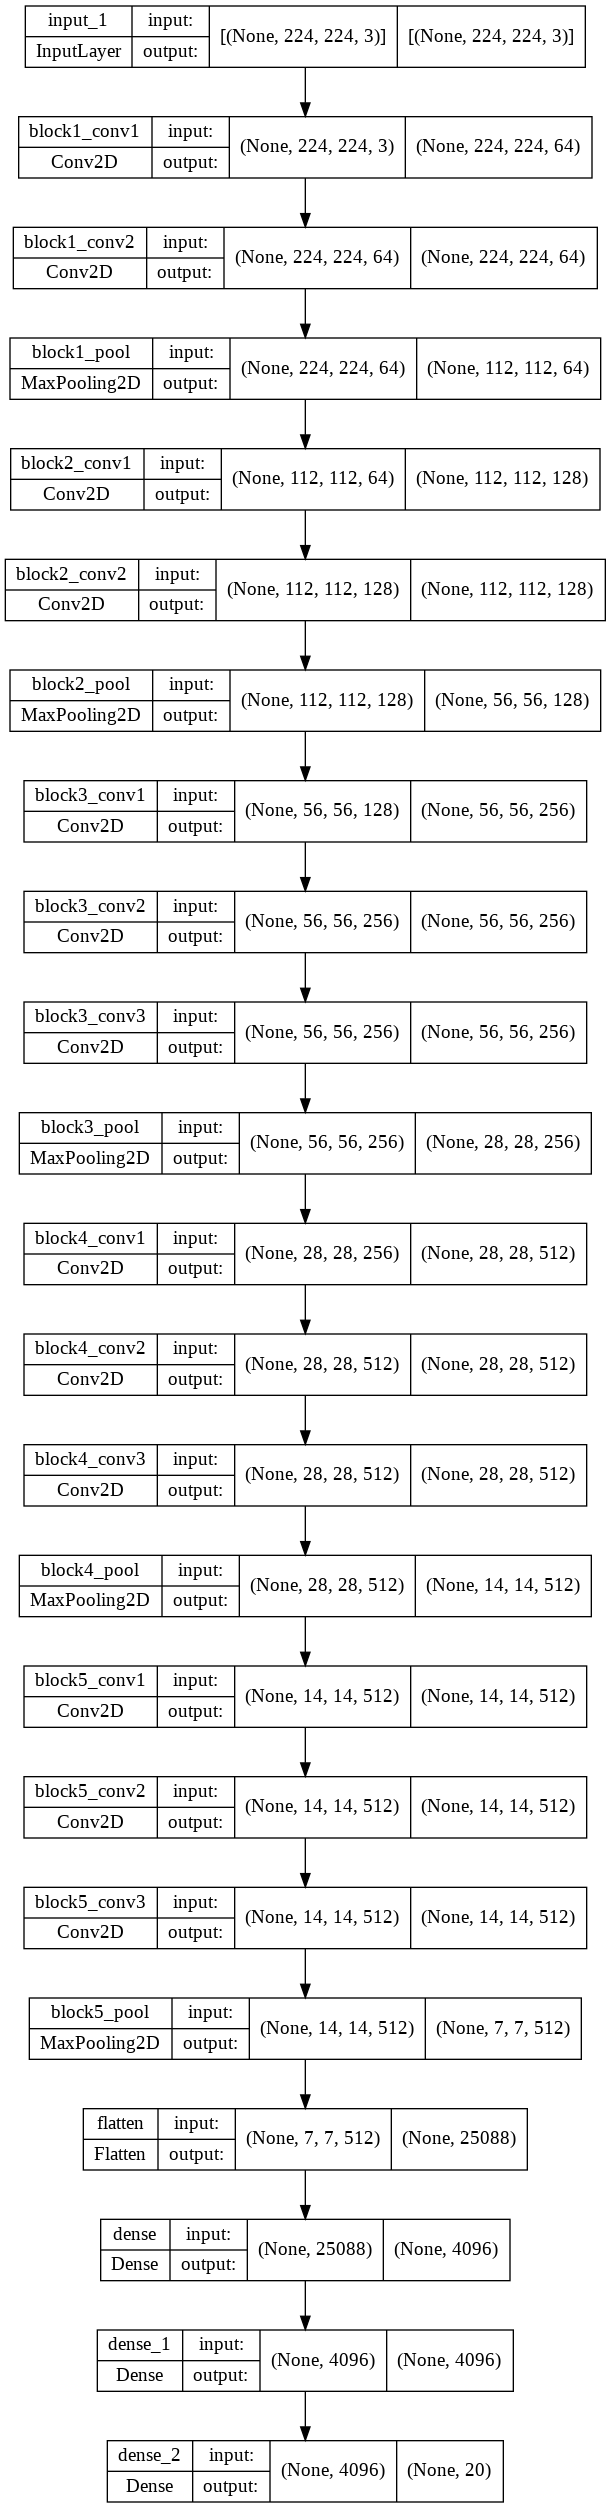

In [18]:
plot_model(BasicModel, show_shapes=True, show_layer_names=True)

In [19]:
BasicModel.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 1338s 22s/step - loss: 4.5687 - accuracy: 0.5088 - val_loss: 0.2547 - val_accuracy: 0.9196
Epoch 2/15
62/62 [==============================] - 1334s 22s/step - loss: 0.3305 - accuracy: 0.9213 - val_loss: 0.2048 - val_accuracy: 0.9321
Epoch 3/15
62/62 [==============================] - 1332s 22s/step - loss: 0.1326 - accuracy: 0.9692 - val_loss: 0.1598 - val_accuracy: 0.9571
Epoch 4/15
62/62 [==============================] - 1331s 22s/step - loss: 0.0645 - accuracy: 0.9778 - val_loss: 0.1863 - val_accuracy: 0.9429
Epoch 5/15
62/62 [==============================] - 1338s 22s/step - loss: 0.0233 - accuracy: 0.9904 - val_loss: 0.1448 - val_accuracy: 0.9607
Epoch 6/15
62/62 [==============================] - 1341s 22s/step - loss: 0.0225 - accuracy: 0.9939 - val_loss: 0.3454 - val_accuracy: 0.9232
Epoch 7/15
62/62 [==============================] - 1363s 22s/step - loss: 0.0719 - accuracy: 0.9778 - val_loss: 0.2937 - val_accuracy: 0.9143

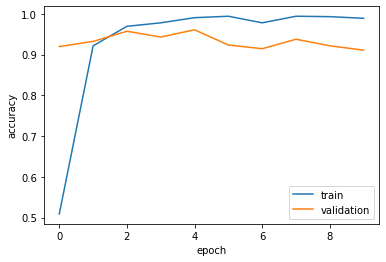

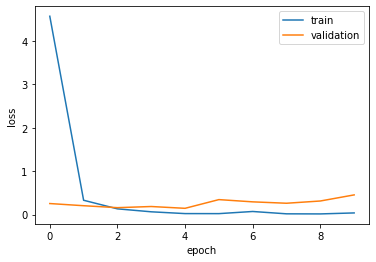

In [20]:
# fit the model
H = BasicModel.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Basic Result/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Basic Result/loss.png', bbox_inches="tight")
plt.show()

BasicModel.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Basic Model.h5")

In [21]:
BasicModel.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 155s 15s/step - loss: 1.2305 - accuracy: 0.8444


[1.230528712272644, 0.8443708419799805]

In [22]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Basic Model.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       1.00      0.79      0.88        19
           2       1.00      0.83      0.91        18
           3       1.00      0.94      0.97        16
           4       0.60      1.00      0.75         9
           5       0.80      1.00      0.89        12
           6       0.67      0.91      0.77        11
           7       0.87      0.93      0.90        14
           8       0.93      0.88      0.90        16
           9       0.88      0.67      0.76        21
          10       0.73      0.79      0.76        14
          11       0.69      0.85      0.76        13
          12       0.80      0.80      0.80        15
          13       0.69      0.79      0.73        14
          14       0.67      0.77      0.71        13
          15       0.93      0.82      0.87        17
          16       0.87      0.93      0.90        14
          17       0.87    

# **Image Processing for 128x128px images**

In [ ]:
train_path="/content/drive/MyDrive/NewFYP/CASIA_128px/train"
test_path="/content/drive/MyDrive/NewFYP/CASIA_128px/test"
val_path="/content/drive/MyDrive/NewFYP/CASIA_128px/val"

In [ ]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(128,128))
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(128,128))
        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(128,128))
        x_val.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
train_x.shape, val_x.shape, test_x.shape

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   brightness_range = (0.5,1.5),
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   fill_mode='constant', cval=255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            batch_size = 32,
                                            class_mode = 'sparse')

In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

# **Model A**

Flatten + Dense(128) + Dropout(0.2) + Dense(64) + Dropout (0.2) + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelA = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelA.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelA.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

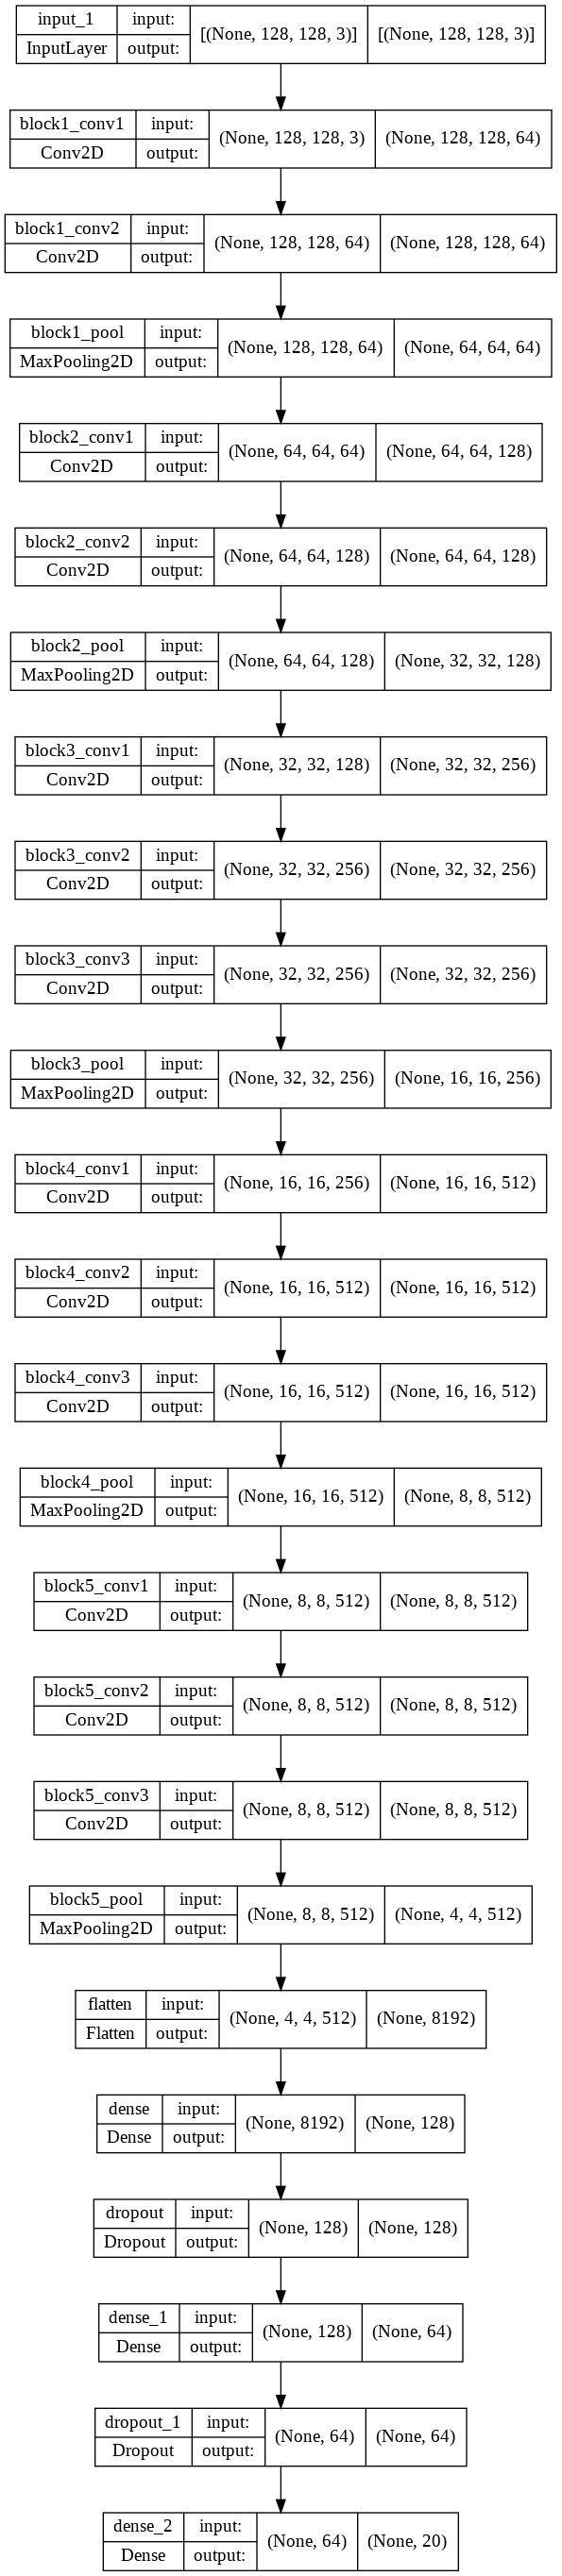

In [ ]:
plot_model(modelA, show_shapes=True, show_layer_names=True)

In [ ]:
modelA.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 432s 7s/step - loss: 2.2952 - accuracy: 0.3046 - val_loss: 1.1657 - val_accuracy: 0.7946
Epoch 2/15
62/62 [==============================] - 429s 7s/step - loss: 1.1498 - accuracy: 0.6843 - val_loss: 0.4796 - val_accuracy: 0.9214
Epoch 3/15
62/62 [==============================] - 425s 7s/step - loss: 0.6721 - accuracy: 0.8200 - val_loss: 0.3239 - val_accuracy: 0.9339
Epoch 4/15
62/62 [==============================] - 408s 7s/step - loss: 0.5112 - accuracy: 0.8573 - val_loss: 0.1892 - val_accuracy: 0.9589
Epoch 5/15
62/62 [==============================] - 408s 7s/step - loss: 0.4068 - accuracy: 0.9017 - val_loss: 0.1470 - val_accuracy: 0.9625
Epoch 6/15
62/62 [==============================] - 409s 7s/step - loss: 0.2796 - accuracy: 0.9309 - val_loss: 0.1415 - val_accuracy: 0.9696
Epoch 7/15
62/62 [==============================] - 409s 7s/step - loss: 0.2594 - accuracy: 0.9284 - val_loss: 0.1233 - val_accuracy: 0.9732
Epoch 8/15
62

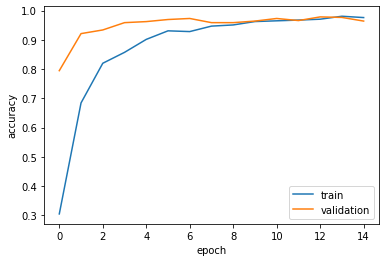

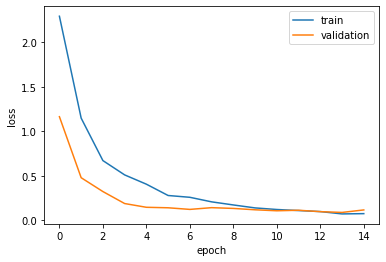

In [ ]:
# fit the model
H = modelA.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result A/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result A/loss.png', bbox_inches="tight")
plt.show()

modelA.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model A.h5")

In [ ]:
modelA.evaluate(train_x,train_y,batch_size=32)

62/62 [==============================] - 292s 5s/step - loss: 0.0066 - accuracy: 0.9990


[0.006644581910222769, 0.9989914298057556]

In [ ]:
modelA.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 85s 5s/step - loss: 0.1173 - accuracy: 0.9643


[0.11730526387691498, 0.9642857313156128]

In [ ]:
modelA.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 51s 5s/step - loss: 0.8315 - accuracy: 0.9007


[0.8314943313598633, 0.9006622433662415]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model A.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16
           2       1.00      0.88      0.94        17
           3       1.00      0.83      0.91        18
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       0.80      1.00      0.89        12
           7       0.93      0.93      0.93        15
           8       0.93      0.93      0.93        15
           9       0.81      0.87      0.84        15
          10       0.80      0.71      0.75        17
          11       0.81      0.87      0.84        15
          12       0.80      0.80      0.80        15
          13       0.75      0.80      0.77        15
          14       0.80      0.80      0.80        15
          15       0.93      0.82      0.87        17
          16       0.80      0.86      0.83        14
          17       0.87    

# **Model B**

Flatten + Dense(128) + Dropout (0.2) + Dense(64) + Dropout (0.2) + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelB = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelB.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelB.layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

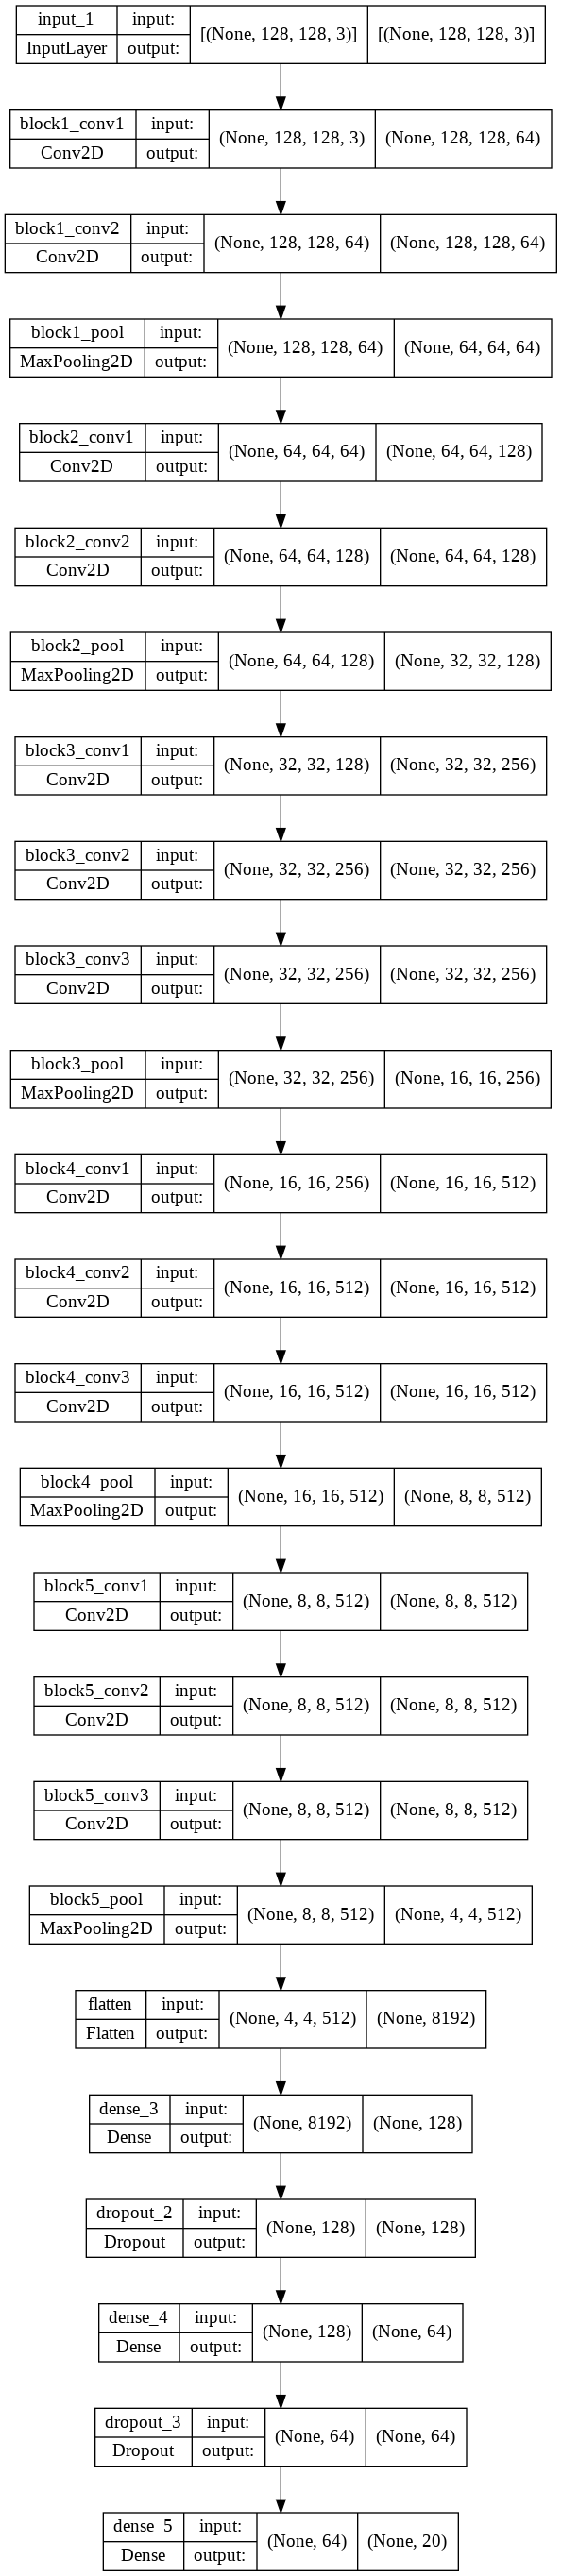

In [ ]:
plot_model(modelB, show_shapes=True, show_layer_names=True)

In [ ]:
modelB.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 379s 6s/step - loss: 2.4484 - accuracy: 0.2698 - val_loss: 1.3242 - val_accuracy: 0.6571
Epoch 2/15
62/62 [==============================] - 375s 6s/step - loss: 1.3551 - accuracy: 0.6046 - val_loss: 0.6730 - val_accuracy: 0.8321
Epoch 3/15
62/62 [==============================] - 372s 6s/step - loss: 0.8899 - accuracy: 0.7574 - val_loss: 0.4436 - val_accuracy: 0.9054
Epoch 4/15
62/62 [==============================] - 369s 6s/step - loss: 0.6488 - accuracy: 0.8316 - val_loss: 0.2239 - val_accuracy: 0.9536
Epoch 5/15
62/62 [==============================] - 368s 6s/step - loss: 0.5176 - accuracy: 0.8563 - val_loss: 0.2604 - val_accuracy: 0.9268
Epoch 6/15
62/62 [==============================] - 368s 6s/step - loss: 0.4360 - accuracy: 0.8880 - val_loss: 0.1669 - val_accuracy: 0.9607
Epoch 7/15
62/62 [==============================] - 371s 6s/step - loss: 0.3435 - accuracy: 0.9042 - val_loss: 0.1645 - val_accuracy: 0.9536
Epoch 8/15
62

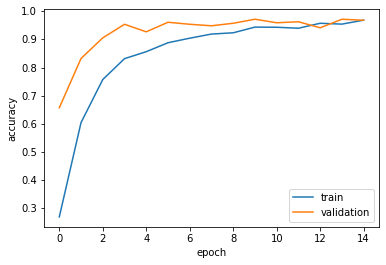

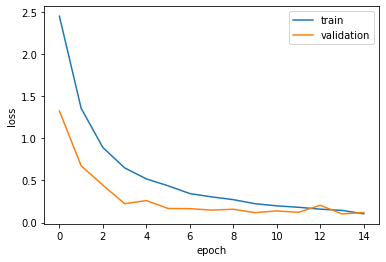

In [ ]:
# fit the model
H = modelB.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result B/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result B/loss.png', bbox_inches="tight")
plt.show()

modelB.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model B.h5")

In [ ]:
modelB.evaluate(train_x,train_y,batch_size=32)

62/62 [==============================] - 317s 5s/step - loss: 0.0200 - accuracy: 0.9945


[0.019974373281002045, 0.9944528341293335]

In [ ]:
modelB.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 90s 5s/step - loss: 0.1193 - accuracy: 0.9679


[0.11931923776865005, 0.9678571224212646]

In [ ]:
modelB.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 54s 5s/step - loss: 0.8833 - accuracy: 0.8841


[0.8832687735557556, 0.8841059803962708]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model B.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        15
           3       1.00      0.88      0.94        17
           4       1.00      1.00      1.00        15
           5       0.93      1.00      0.97        14
           6       0.67      1.00      0.80        10
           7       0.93      0.93      0.93        15
           8       0.93      0.88      0.90        16
           9       0.88      0.88      0.88        16
          10       0.80      0.80      0.80        15
          11       0.75      0.86      0.80        14
          12       0.80      0.71      0.75        17
          13       0.75      0.67      0.71        18
          14       0.67      0.77      0.71        13
          15       0.93      0.82      0.87        17
          16       0.93      0.88      0.90        16
          17       0.87    

# **Model C**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelC = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelC.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelC.layers):
    print(i, layer.name, layer.trainable)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

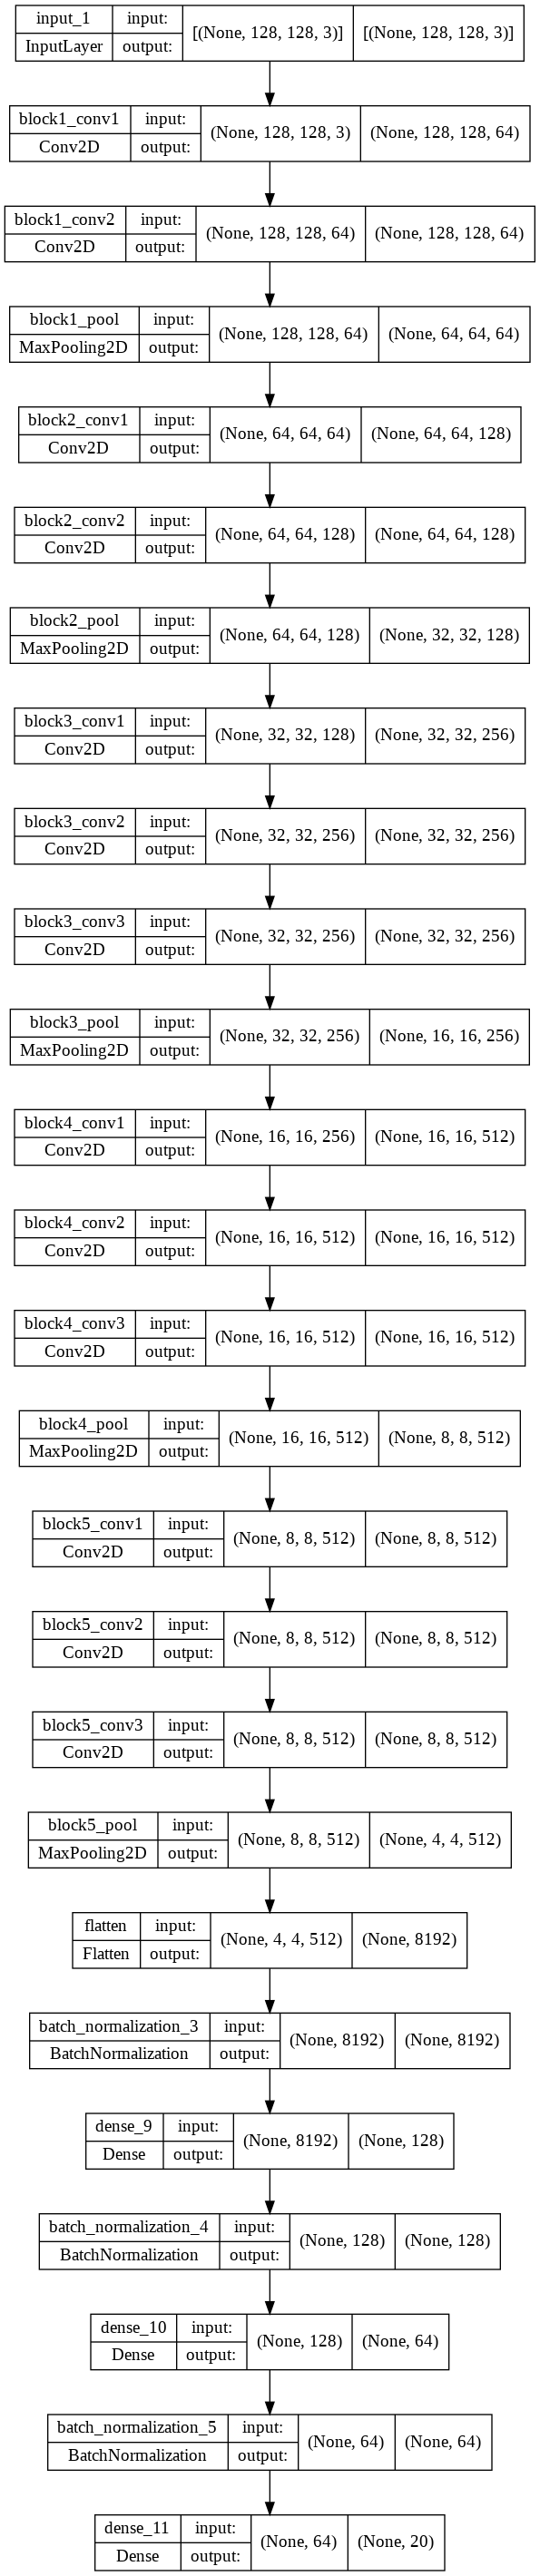

In [ ]:
plot_model(modelC, show_shapes=True, show_layer_names=True)

In [ ]:
modelC.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 426s 7s/step - loss: 1.0125 - accuracy: 0.7584 - val_loss: 1.2564 - val_accuracy: 0.8589
Epoch 2/15
62/62 [==============================] - 416s 7s/step - loss: 0.2186 - accuracy: 0.9652 - val_loss: 0.8623 - val_accuracy: 0.9089
Epoch 3/15
62/62 [==============================] - 416s 7s/step - loss: 0.0902 - accuracy: 0.9889 - val_loss: 0.5504 - val_accuracy: 0.9411
Epoch 4/15
62/62 [==============================] - 415s 7s/step - loss: 0.0396 - accuracy: 0.9975 - val_loss: 0.3552 - val_accuracy: 0.9571
Epoch 5/15
62/62 [==============================] - 416s 7s/step - loss: 0.0249 - accuracy: 0.9990 - val_loss: 0.2375 - val_accuracy: 0.9679
Epoch 6/15
62/62 [==============================] - 413s 7s/step - loss: 0.0157 - accuracy: 0.9995 - val_loss: 0.1858 - val_accuracy: 0.9661
Epoch 7/15
62/62 [==============================] - 413s 7s/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.1527 - val_accuracy: 0.9679
Epoch 8/15
62

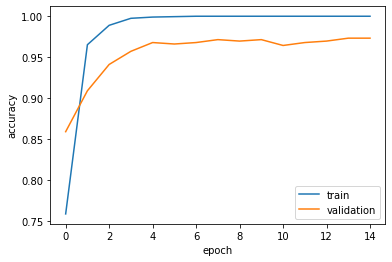

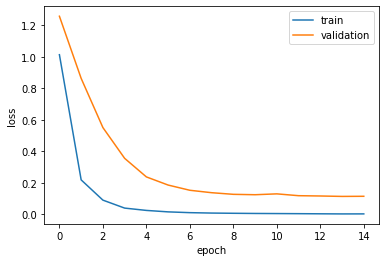

In [ ]:
# fit the model
H = modelC.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result C/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result C/loss.png', bbox_inches="tight")
plt.show()

modelC.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model C.h5")

In [ ]:
modelC.evaluate(train_x,train_y,batch_size=32)

62/62 [==============================] - 288s 5s/step - loss: 5.9992e-04 - accuracy: 1.0000


[0.0005999160930514336, 1.0]

In [ ]:
modelC.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 82s 5s/step - loss: 0.1145 - accuracy: 0.9732


[0.11452354490756989, 0.9732142686843872]

In [ ]:
modelC.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 46s 4s/step - loss: 0.8810 - accuracy: 0.9040


[0.8809714317321777, 0.9039735198020935]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model C.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      0.88      0.94        17
           4       1.00      0.94      0.97        16
           5       0.93      1.00      0.97        14
           6       0.87      1.00      0.93        13
           7       0.93      0.88      0.90        16
           8       0.93      0.93      0.93        15
           9       0.81      0.81      0.81        16
          10       0.87      0.87      0.87        15
          11       0.81      0.87      0.84        15
          12       0.80      0.80      0.80        15
          13       0.75      0.80      0.77        15
          14       0.80      0.80      0.80        15
          15       0.93      0.88      0.90        16
          16       0.93      0.88      0.90        16
          17       0.80    

# **Model D**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelD = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelD.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelD.layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

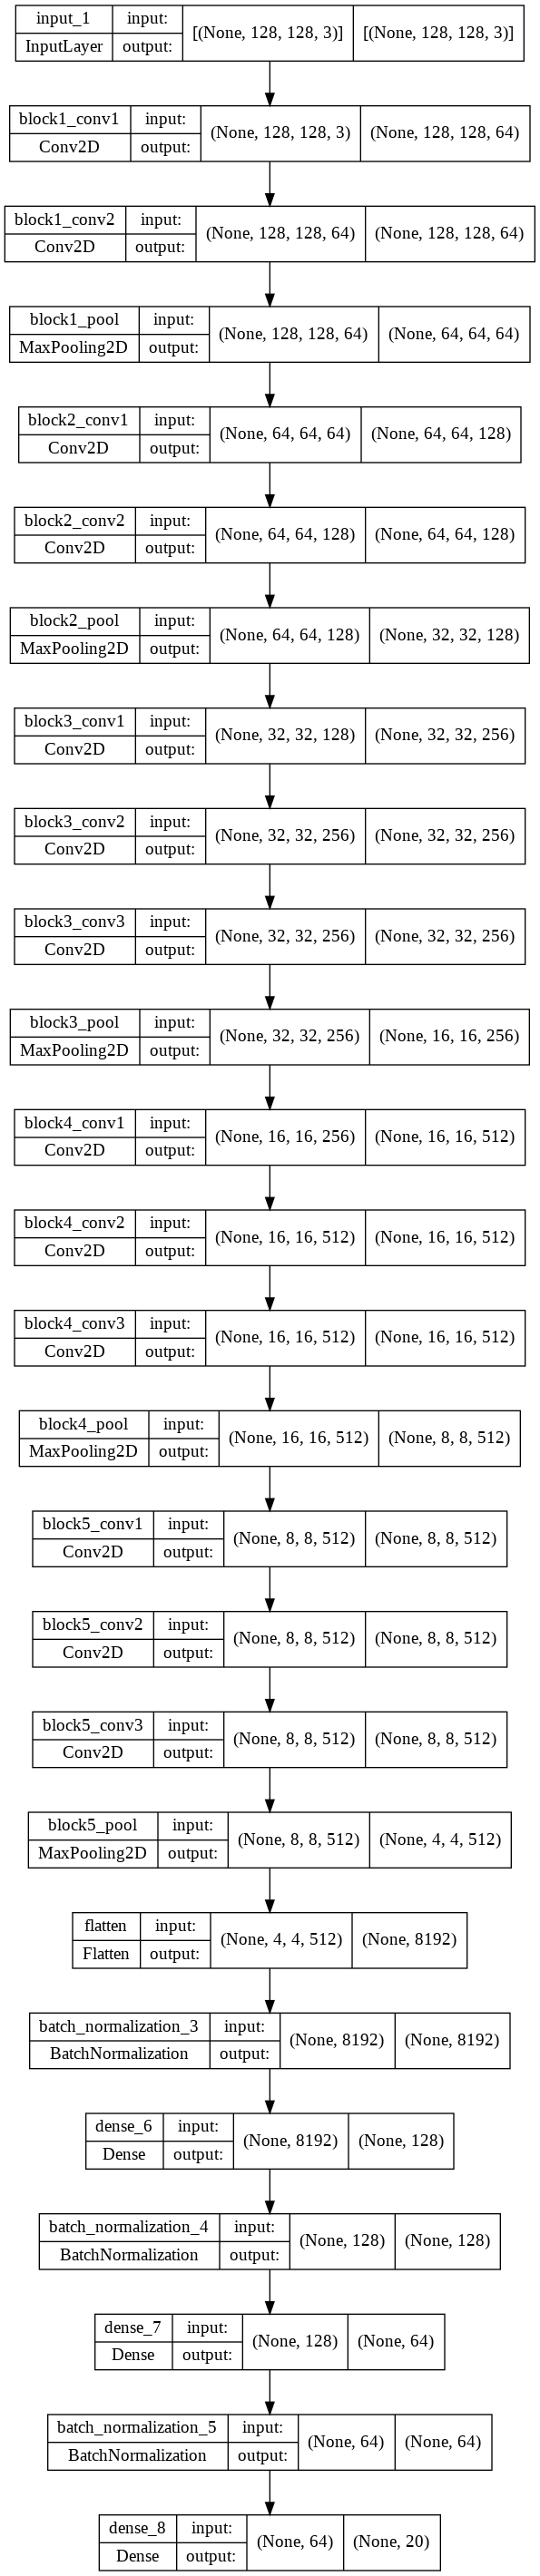

In [ ]:
plot_model(modelD, show_shapes=True, show_layer_names=True)

In [ ]:
modelD.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 371s 6s/step - loss: 0.8624 - accuracy: 0.8033 - val_loss: 1.1988 - val_accuracy: 0.7893
Epoch 2/15
62/62 [==============================] - 369s 6s/step - loss: 0.2078 - accuracy: 0.9657 - val_loss: 0.5972 - val_accuracy: 0.9071
Epoch 3/15
62/62 [==============================] - 373s 6s/step - loss: 0.0741 - accuracy: 0.9899 - val_loss: 0.3489 - val_accuracy: 0.9429
Epoch 4/15
62/62 [==============================] - 372s 6s/step - loss: 0.0325 - accuracy: 0.9970 - val_loss: 0.2511 - val_accuracy: 0.9429
Epoch 5/15
62/62 [==============================] - 372s 6s/step - loss: 0.0148 - accuracy: 0.9980 - val_loss: 0.1514 - val_accuracy: 0.9643
Epoch 6/15
62/62 [==============================] - 370s 6s/step - loss: 0.0101 - accuracy: 0.9990 - val_loss: 0.1115 - val_accuracy: 0.9750
Epoch 7/15
62/62 [==============================] - 372s 6s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9732
Epoch 8/15
62

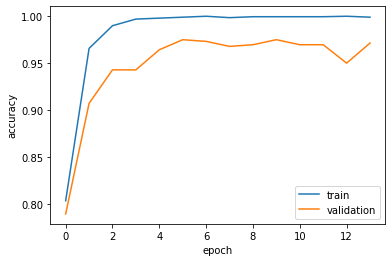

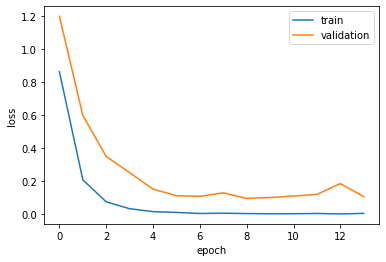

In [ ]:
# fit the model
H = modelD.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result D/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result D/loss.png', bbox_inches="tight")
plt.show()

modelD.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model D.h5")

In [ ]:
modelD.evaluate(train_x,train_y,batch_size=32)

62/62 [==============================] - 309s 5s/step - loss: 5.3376e-05 - accuracy: 1.0000


[5.337577385944314e-05, 1.0]

In [ ]:
modelD.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 81s 4s/step - loss: 0.1058 - accuracy: 0.9714


[0.10583905130624771, 0.9714285731315613]

In [ ]:
modelD.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 51s 5s/step - loss: 1.0065 - accuracy: 0.8907


[1.0065464973449707, 0.8907284736633301]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model D.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        15
           3       1.00      0.94      0.97        16
           4       1.00      0.94      0.97        16
           5       0.93      1.00      0.97        14
           6       0.80      0.92      0.86        13
           7       0.93      0.93      0.93        15
           8       0.93      0.93      0.93        15
           9       0.88      0.88      0.88        16
          10       0.73      0.85      0.79        13
          11       0.75      0.80      0.77        15
          12       0.80      0.71      0.75        17
          13       0.69      0.73      0.71        15
          14       0.87      0.81      0.84        16
          15       0.93      0.88      0.90        16
          16       0.87      0.81      0.84        16
          17       0.87    

# **Model E**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + Adam

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelE = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelE.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelE.layers):
    print(i, layer.name, layer.trainable)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

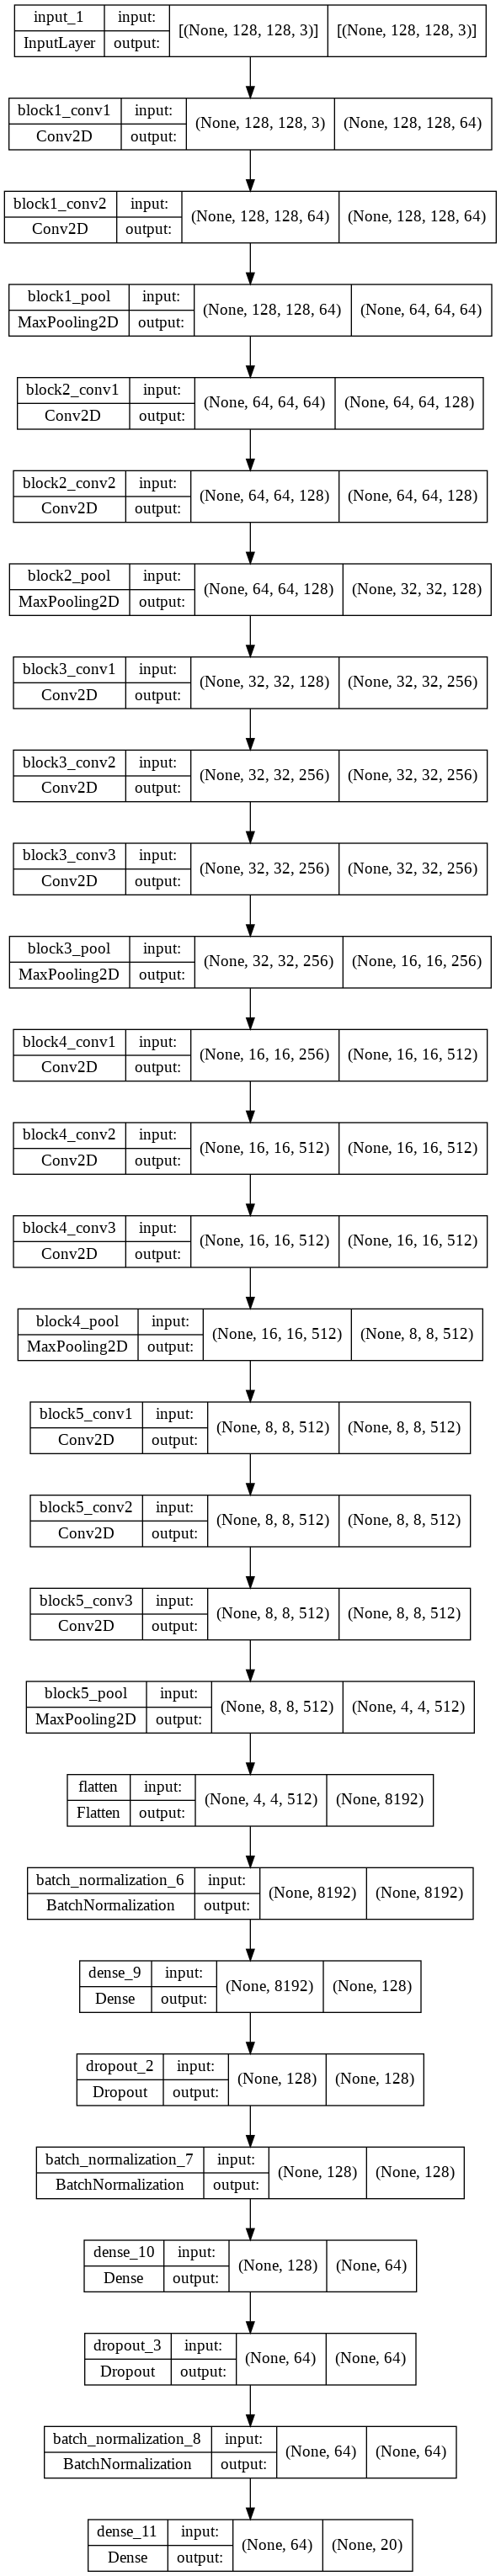

In [ ]:
plot_model(modelE, show_shapes=True, show_layer_names=True)

In [ ]:
modelE.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 376s 6s/step - loss: 1.4650 - accuracy: 0.6203 - val_loss: 1.2639 - val_accuracy: 0.8143
Epoch 2/15
62/62 [==============================] - 370s 6s/step - loss: 0.5246 - accuracy: 0.9198 - val_loss: 0.8065 - val_accuracy: 0.9464
Epoch 3/15
62/62 [==============================] - 369s 6s/step - loss: 0.3126 - accuracy: 0.9460 - val_loss: 0.5079 - val_accuracy: 0.9589
Epoch 4/15
62/62 [==============================] - 369s 6s/step - loss: 0.2196 - accuracy: 0.9672 - val_loss: 0.3139 - val_accuracy: 0.9607
Epoch 5/15
62/62 [==============================] - 368s 6s/step - loss: 0.1454 - accuracy: 0.9783 - val_loss: 0.2273 - val_accuracy: 0.9607
Epoch 6/15
62/62 [==============================] - 369s 6s/step - loss: 0.1027 - accuracy: 0.9889 - val_loss: 0.1585 - val_accuracy: 0.9714
Epoch 7/15
62/62 [==============================] - 369s 6s/step - loss: 0.0822 - accuracy: 0.9889 - val_loss: 0.1440 - val_accuracy: 0.9696
Epoch 8/15
62

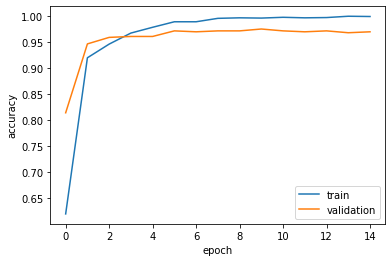

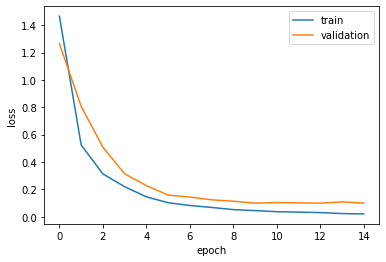

In [ ]:
# fit the model
H = modelE.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result E/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result E/loss.png', bbox_inches="tight")
plt.show()

modelE.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model E.h5")

In [ ]:
modelE.evaluate(train_x,train_y,batch_size=32)

62/62 [==============================] - 294s 5s/step - loss: 7.1479e-04 - accuracy: 1.0000


[0.0007147946744225919, 1.0]

In [ ]:
modelE.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 80s 4s/step - loss: 0.1001 - accuracy: 0.9696


[0.1001041978597641, 0.9696428775787354]

In [ ]:
modelE.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 46s 4s/step - loss: 0.7441 - accuracy: 0.8974


[0.7441031336784363, 0.8973509669303894]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model E.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      0.88      0.94        17
           4       1.00      0.94      0.97        16
           5       1.00      1.00      1.00        15
           6       0.87      1.00      0.93        13
           7       0.93      0.88      0.90        16
           8       0.93      0.93      0.93        15
           9       0.81      0.87      0.84        15
          10       0.73      0.85      0.79        13
          11       0.81      0.87      0.84        15
          12       0.80      0.75      0.77        16
          13       0.75      0.80      0.77        15
          14       0.87      0.81      0.84        16
          15       0.87      0.87      0.87        15
          16       0.93      0.82      0.87        17
          17       0.73    

# **Model F**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + Rmsprop

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelF = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelF.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelF.layers):
    print(i, layer.name, layer.trainable)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

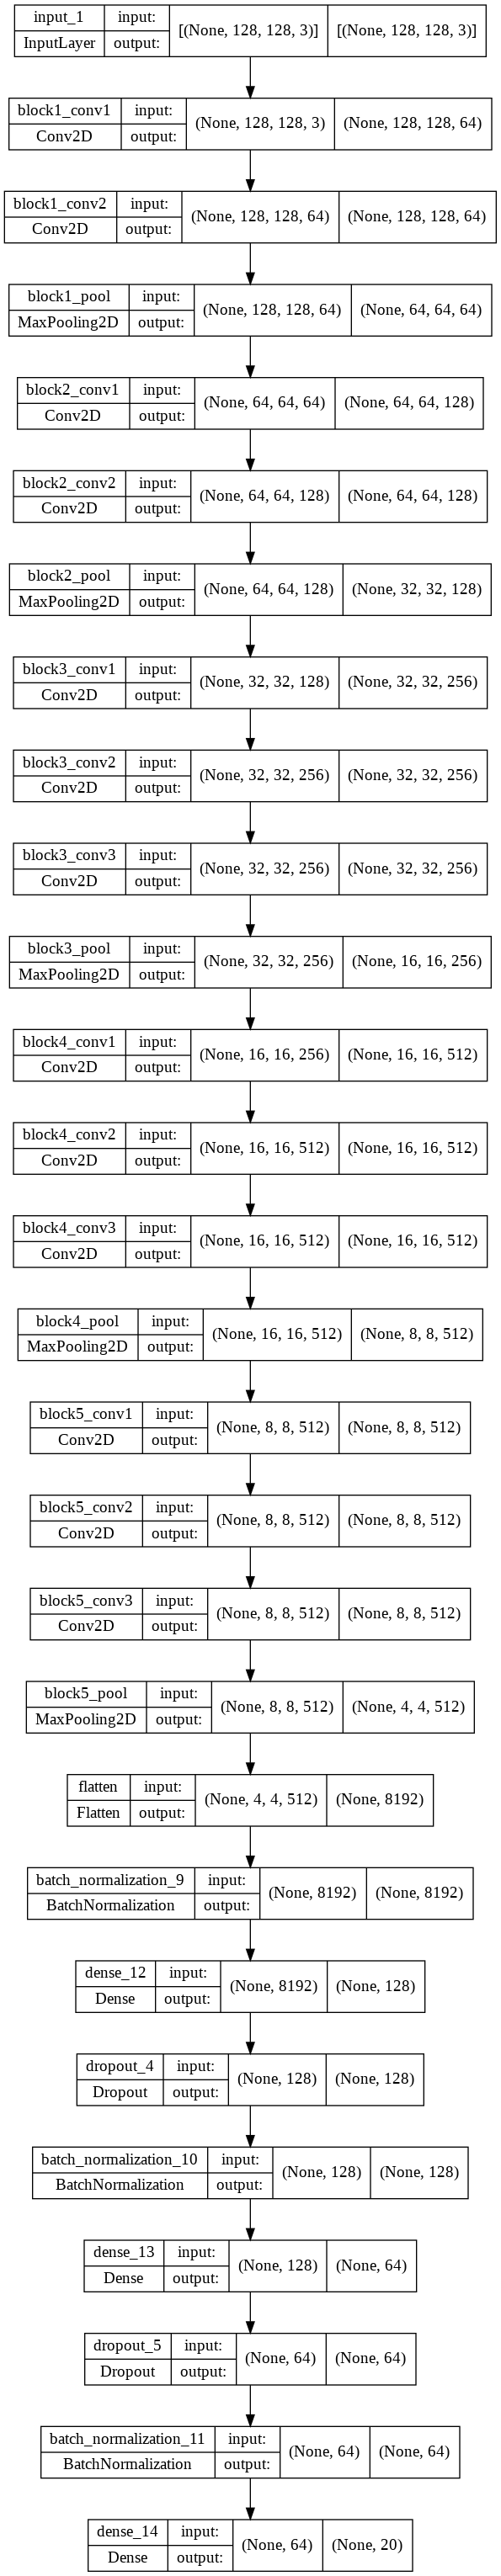

In [ ]:
plot_model(modelF, show_shapes=True, show_layer_names=True)

In [ ]:
modelF.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="rmsprop",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 378s 6s/step - loss: 1.2957 - accuracy: 0.6873 - val_loss: 1.3657 - val_accuracy: 0.8250
Epoch 2/15
62/62 [==============================] - 367s 6s/step - loss: 0.4921 - accuracy: 0.9218 - val_loss: 0.7530 - val_accuracy: 0.9214
Epoch 3/15
62/62 [==============================] - 368s 6s/step - loss: 0.2912 - accuracy: 0.9536 - val_loss: 0.4203 - val_accuracy: 0.9482
Epoch 4/15
62/62 [==============================] - 367s 6s/step - loss: 0.1936 - accuracy: 0.9652 - val_loss: 0.2624 - val_accuracy: 0.9661
Epoch 5/15
62/62 [==============================] - 367s 6s/step - loss: 0.1294 - accuracy: 0.9783 - val_loss: 0.1829 - val_accuracy: 0.9661
Epoch 6/15
62/62 [==============================] - 365s 6s/step - loss: 0.0845 - accuracy: 0.9879 - val_loss: 0.1567 - val_accuracy: 0.9679
Epoch 7/15
62/62 [==============================] - 365s 6s/step - loss: 0.0554 - accuracy: 0.9924 - val_loss: 0.1099 - val_accuracy: 0.9750
Epoch 8/15
62

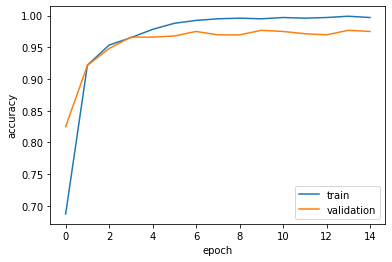

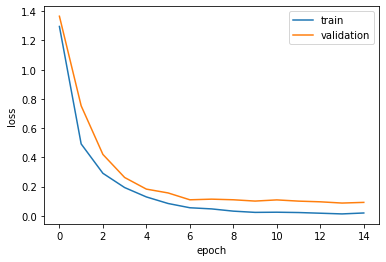

In [ ]:
# fit the model
H = modelF.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result F/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result F/loss.png', bbox_inches="tight")
plt.show()

modelF.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model F.h5")

In [ ]:
modelF.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 299s 5s/step - loss: 1.9458e-04 - accuracy: 1.0000


[0.0001945846015587449, 1.0]

In [ ]:
modelF.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 81s 4s/step - loss: 0.0922 - accuracy: 0.9750


[0.09217189997434616, 0.9750000238418579]

In [ ]:
modelF.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 62s 6s/step - loss: 0.7342 - accuracy: 0.9073


[0.7341839671134949, 0.9072847962379456]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model F.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        15
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       0.87      1.00      0.93        13
           7       0.93      0.88      0.90        16
           8       0.93      0.93      0.93        15
           9       0.81      0.87      0.84        15
          10       0.80      0.80      0.80        15
          11       0.81      0.87      0.84        15
          12       0.80      0.75      0.77        16
          13       0.75      0.80      0.77        15
          14       0.87      0.81      0.84        16
          15       0.93      0.82      0.87        17
          16       0.93      0.93      0.93        15
          17       0.87    

# **Model G**

Flatten + Dense(128) + Dropout(0.2) + Dense(64) + Dropout(0.2) + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = Dense(20,activation = "softmax")(X)

modelG = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelG.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelG.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

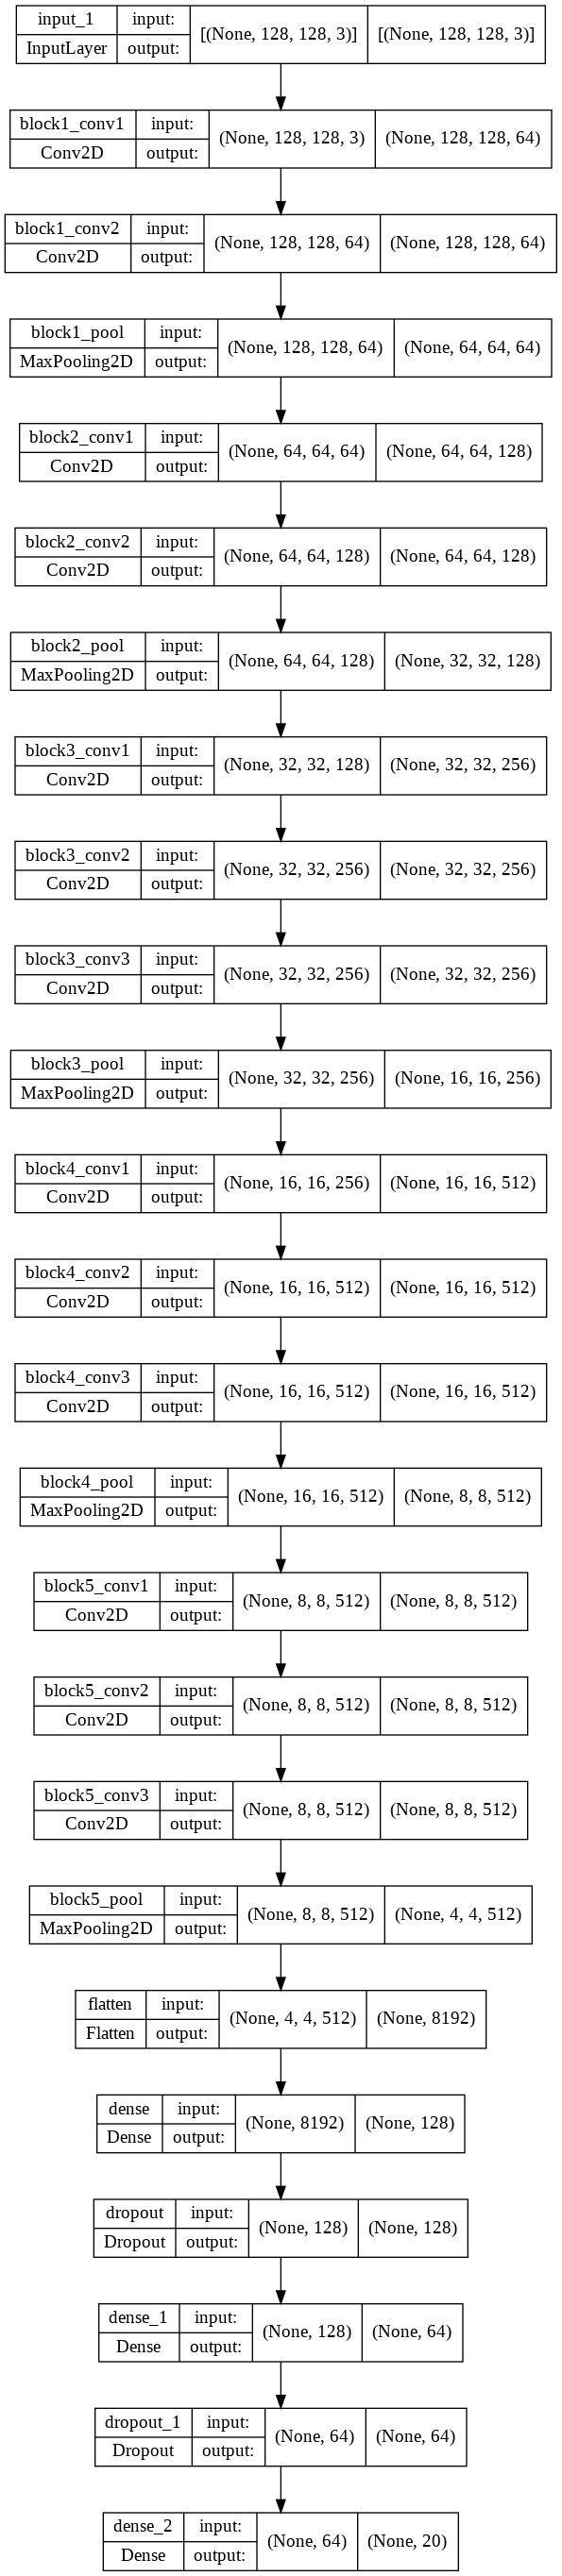

In [ ]:
plot_model(modelG, show_shapes=True, show_layer_names=True)

In [ ]:
modelG.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 378s 6s/step - loss: 2.9525 - accuracy: 0.0903 - val_loss: 2.7958 - val_accuracy: 0.1125
Epoch 2/15
62/62 [==============================] - 377s 6s/step - loss: 2.7668 - accuracy: 0.1513 - val_loss: 2.5821 - val_accuracy: 0.3054
Epoch 3/15
62/62 [==============================] - 375s 6s/step - loss: 2.5288 - accuracy: 0.2365 - val_loss: 2.1757 - val_accuracy: 0.5125
Epoch 4/15
62/62 [==============================] - 372s 6s/step - loss: 2.2391 - accuracy: 0.3369 - val_loss: 1.8677 - val_accuracy: 0.6589
Epoch 5/15
62/62 [==============================] - 374s 6s/step - loss: 1.9536 - accuracy: 0.4276 - val_loss: 1.5799 - val_accuracy: 0.6179
Epoch 6/15
62/62 [==============================] - 373s 6s/step - loss: 1.7030 - accuracy: 0.5033 - val_loss: 1.2911 - val_accuracy: 0.7429
Epoch 7/15
62/62 [==============================] - 372s 6s/step - loss: 1.5064 - accuracy: 0.5764 - val_loss: 1.0028 - val_accuracy: 0.8018
Epoch 8/15
62

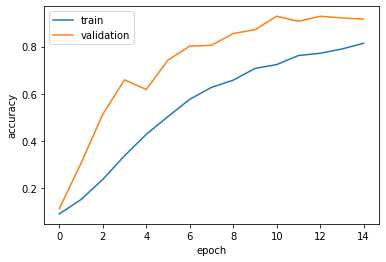

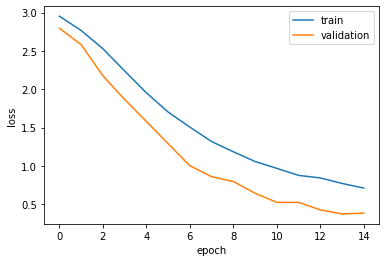

In [ ]:
# fit the model
H = modelG.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result G/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result G/loss.png', bbox_inches="tight")
plt.show()

modelG.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model G.h5")

In [ ]:
modelG.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 303s 5s/step - loss: 0.4216 - accuracy: 0.9294


[0.4215998351573944, 0.9293999075889587]

In [ ]:
modelG.evaluate(val_x,val_y,batch_size=32)

18/18 [==============================] - 82s 5s/step - loss: 0.3845 - accuracy: 0.9161


[0.3845125436782837, 0.9160714149475098]

In [ ]:
modelG.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 53s 5s/step - loss: 0.7413 - accuracy: 0.8642


[0.741274356842041, 0.8642383813858032]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model G.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       1.00      0.88      0.94        17
           2       0.87      0.93      0.90        14
           3       1.00      1.00      1.00        15
           4       1.00      0.94      0.97        16
           5       1.00      0.88      0.94        17
           6       0.87      0.76      0.81        17
           7       0.93      0.70      0.80        20
           8       0.93      0.93      0.93        15
           9       0.88      0.88      0.88        16
          10       0.67      0.83      0.74        12
          11       0.56      0.90      0.69        10
          12       0.80      0.92      0.86        13
          13       0.69      0.79      0.73        14
          14       0.87      0.76      0.81        17
          15       0.93      0.78      0.85        18
          16       0.87      0.87      0.87        15
          17       0.80    

# **Model H**

Flatten + BatchNormalization + Dense(128) + BatchNormalization + Dense(64) + BatchNormalization + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelH = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelH.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelH.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

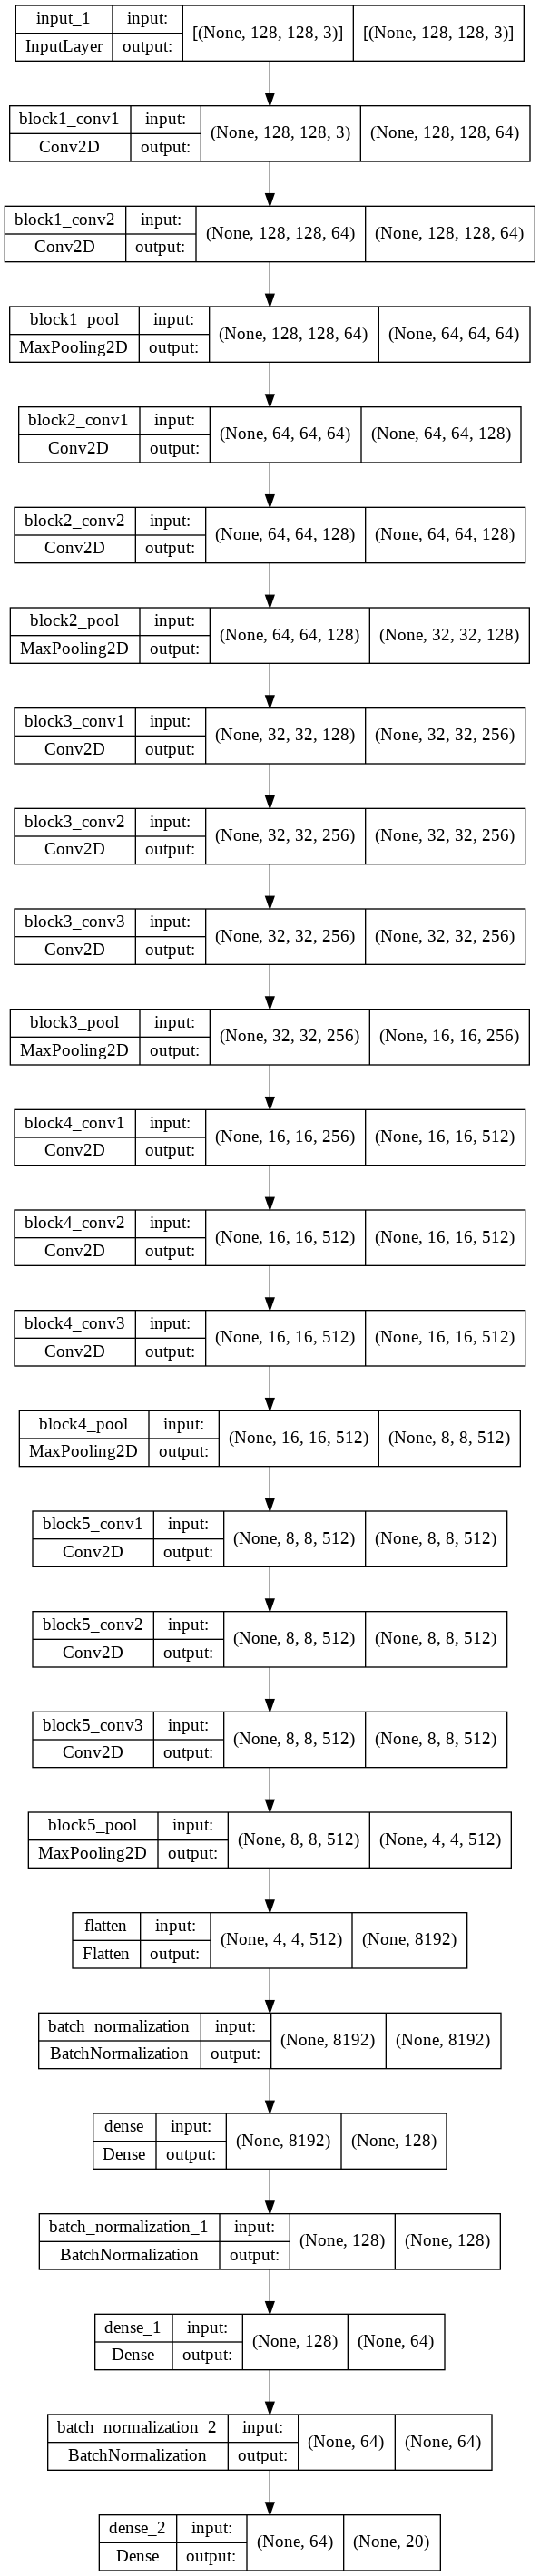

In [ ]:
plot_model(modelH, show_shapes=True, show_layer_names=True)

In [ ]:
modelH.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 336s 5s/step - loss: 1.5001 - accuracy: 0.6162 - val_loss: 2.0068 - val_accuracy: 0.7643
Epoch 2/15
62/62 [==============================] - 328s 5s/step - loss: 0.5256 - accuracy: 0.9304 - val_loss: 1.4859 - val_accuracy: 0.8571
Epoch 3/15
62/62 [==============================] - 342s 6s/step - loss: 0.3355 - accuracy: 0.9667 - val_loss: 1.0947 - val_accuracy: 0.8768
Epoch 4/15
62/62 [==============================] - 341s 6s/step - loss: 0.2365 - accuracy: 0.9778 - val_loss: 0.7848 - val_accuracy: 0.9179
Epoch 5/15
62/62 [==============================] - 329s 5s/step - loss: 0.1801 - accuracy: 0.9844 - val_loss: 0.5798 - val_accuracy: 0.9232
Epoch 6/15
62/62 [==============================] - 331s 5s/step - loss: 0.1426 - accuracy: 0.9909 - val_loss: 0.4541 - val_accuracy: 0.9321
Epoch 7/15
62/62 [==============================] - 334s 5s/step - loss: 0.1126 - accuracy: 0.9950 - val_loss: 0.3794 - val_accuracy: 0.9375
Epoch 8/15
62

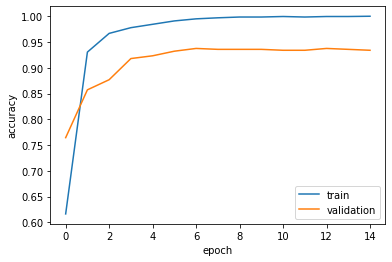

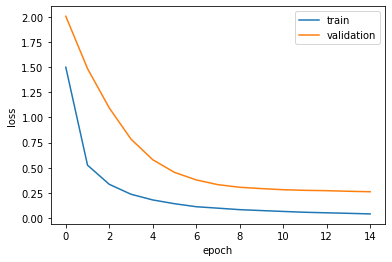

In [ ]:
# fit the model
H = modelH.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result H/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result H/loss.png', bbox_inches="tight")
plt.show()

modelH.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model H.h5")

In [ ]:
modelH.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 299s 5s/step - loss: 0.0179 - accuracy: 1.0000


[0.017911335453391075, 1.0]

In [ ]:
modelH.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 100s 5s/step - loss: 0.2616 - accuracy: 0.9339


[0.2615630626678467, 0.9339285492897034]

In [ ]:
modelH.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 46s 4s/step - loss: 0.7106 - accuracy: 0.8709


[0.7106239795684814, 0.8708609342575073]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model H.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      0.93      0.93        15
           2       0.87      1.00      0.93        13
           3       1.00      0.83      0.91        18
           4       0.93      1.00      0.97        14
           5       0.93      0.93      0.93        15
           6       0.73      1.00      0.85        11
           7       0.93      0.88      0.90        16
           8       0.93      0.93      0.93        15
           9       0.81      0.81      0.81        16
          10       0.73      0.85      0.79        13
          11       0.75      0.86      0.80        14
          12       0.80      0.71      0.75        17
          13       0.75      0.71      0.73        17
          14       0.87      0.81      0.84        16
          15       0.87      0.87      0.87        15
          16       0.87      0.72      0.79        18
          17       0.80    

# **Model I**

Flatten + BatchNormalization + Dense(128) + Dropout (0.2) + BatchNormalization + Dense(64) + Dropout (0.2) + BatchNormalization + Dense(20) + SGD

In [ ]:
#do not train the pre-trained layers of VGG-16
for layer in vgg16.layers:
    layer.trainable = False 

X = vgg16.output
X = Flatten(name="flatten")(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(128,activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(64, activation = "relu")(X)
X = Dropout(0.2)(X)
X = BatchNormalization(axis=-1)(X)
X = Dense(20,activation = "softmax")(X)

modelI = Model(inputs=vgg16.input, outputs=X)

In [ ]:
# view the structure of the model
modelI.summary()
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelI.layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

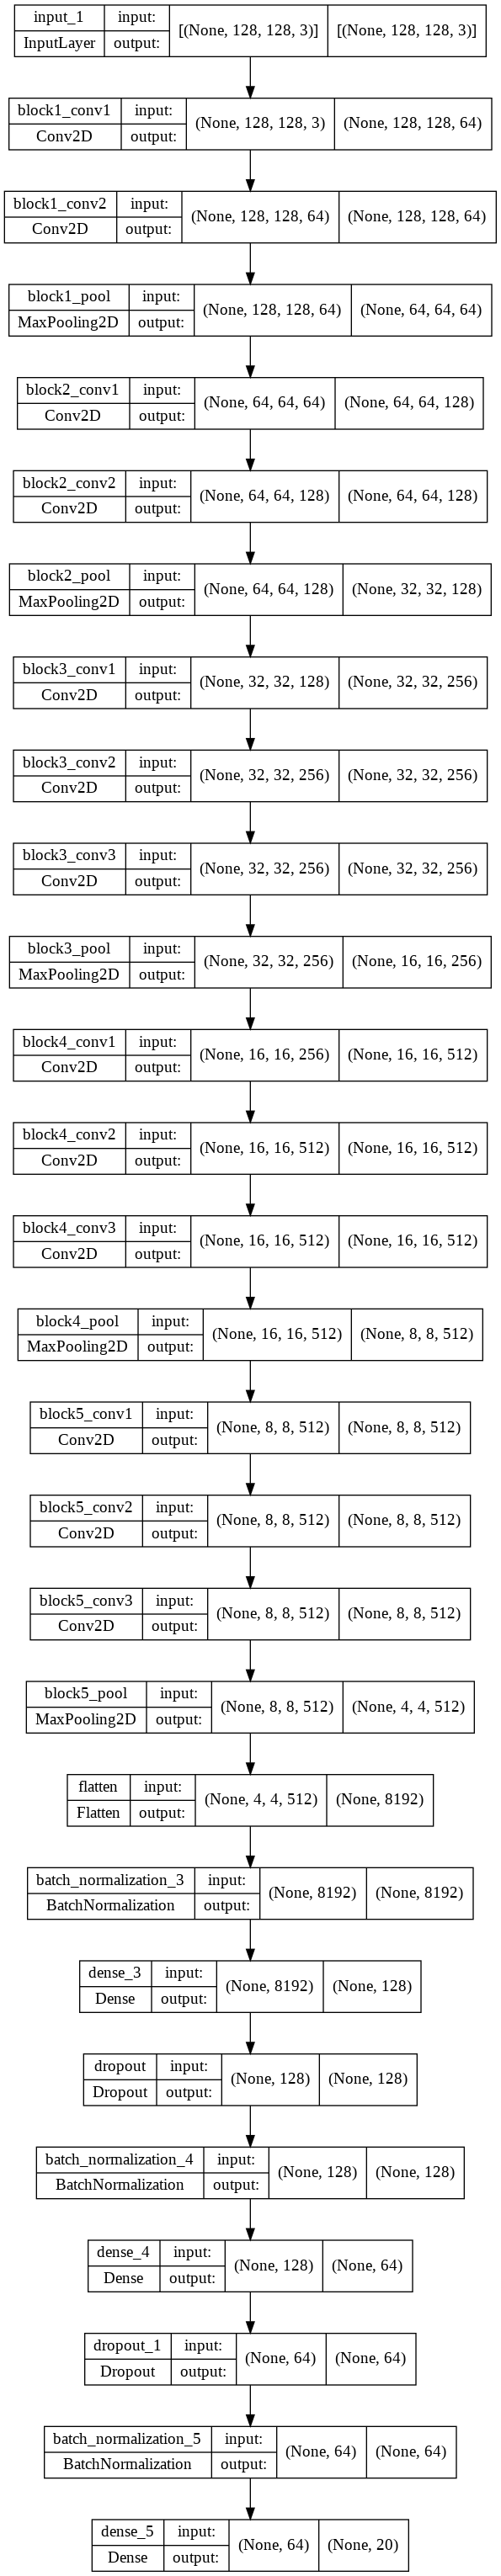

In [ ]:
plot_model(modelI, show_shapes=True, show_layer_names=True)

In [ ]:
modelI.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="SGD",
  metrics=['accuracy']
)

#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

Epoch 1/15
62/62 [==============================] - 340s 5s/step - loss: 2.0494 - accuracy: 0.4271 - val_loss: 2.2406 - val_accuracy: 0.5625
Epoch 2/15
62/62 [==============================] - 334s 5s/step - loss: 1.0773 - accuracy: 0.7625 - val_loss: 1.6570 - val_accuracy: 0.7875
Epoch 3/15
62/62 [==============================] - 348s 6s/step - loss: 0.7894 - accuracy: 0.8618 - val_loss: 1.2017 - val_accuracy: 0.8946
Epoch 4/15
62/62 [==============================] - 332s 5s/step - loss: 0.6176 - accuracy: 0.8936 - val_loss: 0.8450 - val_accuracy: 0.9268
Epoch 5/15
62/62 [==============================] - 328s 5s/step - loss: 0.5242 - accuracy: 0.9249 - val_loss: 0.6111 - val_accuracy: 0.9411
Epoch 6/15
62/62 [==============================] - 332s 5s/step - loss: 0.4478 - accuracy: 0.9334 - val_loss: 0.4693 - val_accuracy: 0.9464
Epoch 7/15
62/62 [==============================] - 330s 5s/step - loss: 0.3991 - accuracy: 0.9440 - val_loss: 0.3773 - val_accuracy: 0.9518
Epoch 8/15
62

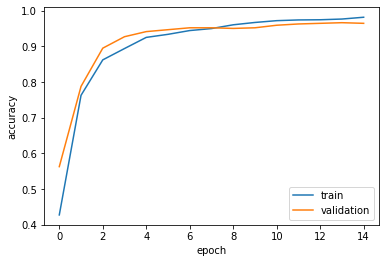

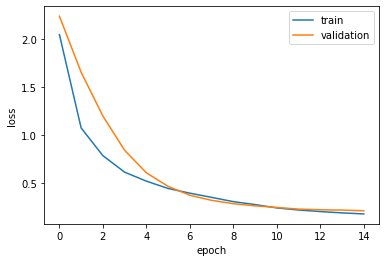

In [ ]:
# fit the model
H = modelI.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

#Plot the Graph

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result I/acc.png', bbox_inches="tight")
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('/content/drive/MyDrive/NewFYP/CASIA_128px/Result/Result I/loss.png', bbox_inches="tight")
plt.show()

modelI.save("/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model I.h5")

In [ ]:
modelI.evaluate(train_x,train_y,batch_size=32) 

62/62 [==============================] - 305s 5s/step - loss: 0.0387 - accuracy: 0.9970


[0.03870156407356262, 0.9969742894172668]

In [ ]:
modelI.evaluate(val_x,val_y,batch_size=32) 

18/18 [==============================] - 96s 5s/step - loss: 0.2156 - accuracy: 0.9643


[0.2155567705631256, 0.9642857313156128]

In [ ]:
modelI.evaluate(test_x,test_y,batch_size=32) 

10/10 [==============================] - 50s 5s/step - loss: 0.6119 - accuracy: 0.8874


[0.6119357347488403, 0.887417197227478]

In [ ]:
import numpy as np
#predict
model = keras.models.load_model('/content/drive/MyDrive/NewFYP/CASIA_128px/Model/Model I.h5')

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        16
           2       0.87      1.00      0.93        13
           3       1.00      0.88      0.94        17
           4       1.00      0.94      0.97        16
           5       1.00      0.83      0.91        18
           6       0.87      0.87      0.87        15
           7       0.93      0.93      0.93        15
           8       0.93      0.93      0.93        15
           9       0.81      0.87      0.84        15
          10       0.73      0.85      0.79        13
          11       0.81      0.81      0.81        16
          12       0.73      0.85      0.79        13
          13       0.75      0.80      0.77        15
          14       0.80      0.80      0.80        15
          15       0.93      0.88      0.90        16
          16       0.93      0.82      0.87        17
          17       0.80    